<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/beam-data/cv-intro/blob/master/notebooks/solutions/tf2-intro-solutions.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/beam-data/cv-intro/blob/master/notebooks/solutions/tf2-intro-solutions.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td><td>
  <a target="_blank"  href="http://beamdata.ca/">
    <img width=128px src="https://weclouddata.com/wp-content/uploads/2019/06/logo-w@3x.png" /></a>
</td></table>

In [ ]:
#@title Install Dependencies
#get your dependencies on
!pip install -U kora
#!pip install tf-nightly
!pip install seaborn
!pip install tensorflow_hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#%tensorflow_version 1.x

In [ ]:
tf.__version__

'2.4.1'

#Setup

Alright! Before we get started let's check we have a GPU available as it'll dramatically improve our training and inference time. Mak sure that **Hardware Accelarator** option in  **Runtime - Change Runtime Type** is set to GPU.

GPU's started life as single operation multiple data powerhouse. Workhorse dedicated to vector translation, rasterisation, convolutions etc It quickly became apparent in our lifetimes that the SIMD paradigm can be utilised in conjunction with Deep Learning and we're beginning to see hardware become more and more specialised as a result.

Let's actually take the opportunity investigate first of all whether a GPU is available to us and also which model:


In [ ]:
#check wether or not we're using a GPU
is_gpu = len(tf.config.experimental.list_physical_devices('GPU')) > 0
print(is_gpu)

True


In [ ]:
!nvidia-smi

Thu Apr  8 07:27:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We're pretty lucky here in that Collaboratory is able to offer us Tesla K80's to work with subject to demaand. For those of you who are lucky enough to have Colab Pro, access to P100's and V100's is a dream with the latter offering a huge performance enhacement with dedicated mixed precision tensor cores.

# Our first model
ANN's are easy to build with Keras' high-level API and a Tensorflow backend. Since Tensorflow 2 Keras has become it's official high level API. While the API provides us with a fucntional approach for advanced usage a sequential approach is also available to help visualise the layers of you nn. Let's stick with that approach for now.


The beautiful thing about Tensorflow 2 is that is uses eager execution for a better control flow, allowing us to evaluate operations immediately instead of having to build graphs, whilst retaining the ability to do so on the fly with some handy decorators.

Let's invesitgate these concepts by revisiting the XOR problem. 

# The Perceptron



![perceptron](https://www.simplilearn.com/ice9/free_resources_article_thumb/general-diagram-of-perceptron-for-supervised-learning.jpg)



In [ ]:
#Heaveside step function is super simple
def predict(X):
        return 1 * (X > 0)
        #return np.where(X >= 0.0, 1, 0)

In [ ]:
predict(-1)

0

In [ ]:
#What are these?
X = np.array([[0, 0], [0, 1], [1,0], [1, 1]])

gates = {'OR': np.array([0,1,1,1]),
         'AND': np.array([0,0,0,1]),
         'XOR': np.array([0,1,1,0])}

In [ ]:
#let's go sklearn!
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier

h = .02  # step size in the mesh
perceptron = Perceptron(max_iter=1000, eta0=0.1).fit(X, gates['OR'])
random_forest = RandomForestClassifier(random_state=1, n_estimators=100).fit(X,gates['OR'])


In [ ]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])

print(Z)

[0 0 0 ... 1 1 1]


In [ ]:
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



def plot_decision(X,y,model,size =(8,8), output_class = False):
  
  if model == 'perceptron':
    model = Perceptron(max_iter=1000, eta0=0.1).fit(X,y)

  elif model == 'random forest':
    model = RandomForestClassifier(random_state=1, n_estimators=100).fit(X,y)
 

 
  h = .02  # step size in the mesh
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

  fig, ax = plt.subplots(figsize=size)
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  #print(Z)
  
  if output_class:
    Z = Z >0.5

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z)
  ax.axis('on')

  # Plot also the training points
  ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
  plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

gate = widgets.Dropdown(
    options=['OR','AND', 'XOR'],
    description='Choose data:',
)

model = widgets.Dropdown(
    options=['perceptron', 'random forest'],
    description='Choose data:',
)

out = widgets.Output()

def on_change(change):
    #print(change.new)
    with out:
      clear_output()
      plot_decision(X,gates[change.new],model.value)



#model.observe(on_change, names='value')
gate.observe(on_change, names='value')

display(gate)
display(model)
display(out)


Dropdown(description='Choose data:', options=('OR', 'AND', 'XOR'), value='OR')

Dropdown(description='Choose data:', options=('perceptron', 'random forest'), value='perceptron')

Output()

#Fully connected shallow networks

![shallow](https://i.stack.imgur.com/BVZro.png)

As mentioned earlier it ha become pretty easy to work with Tensorflow on the fly without a pre-defined graph. LEt's take a look!

In [ ]:
x = tf.constant([[123],[456]])

In [ ]:
print(x)

tf.Tensor(
[[123]
 [456]], shape=(2, 1), dtype=int32)


In [ ]:
x = tf.zeros((3,2))

In [ ]:
print(x)

tf.Tensor(
[[0. 0.]
 [0. 0.]
 [0. 0.]], shape=(3, 2), dtype=float32)


In [ ]:
#Let's create some dummy data
#X = tf.constant(tf.random.uniform([1,1024], maxval=1, dtype=tf.dtypes.float32, seed=1))

X = tf.constant(X, dtype=tf.dtypes.float32)
X

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32)>

In [ ]:
y = tf.constant([0,1,1,0], dtype=tf.dtypes.float32)

In [ ]:
#Weights and bias
w1 = tf.Variable(tf.random.normal([2, 2], seed=1))
w2 = tf.Variable(tf.random.normal([2,], seed=1))
b1 = tf.Variable(tf.random.normal([2,], seed=1))

#w1 = tf.Variable([[1,1], [1,1]], dtype=tf.dtypes.float32)
#w2 = tf.Variable([1,-2], dtype=tf.dtypes.float32)
#b1 = tf.Variable([0,-1], dtype=tf.dtypes.float32)

In [ ]:
b1

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.78232855, -0.29677236], dtype=float32)>

Despite  we're still able to covert a custom function to it's graph representation with the super handy `@tf.function` decorator. Enabling a speedup with custom code. Any ideas how we'd go about creating a standard Dense layer given what we know about perceptrons?

**hint** - I'll get you started with `tf.matmul`

In [ ]:
#your code here
@tf.function
def add(a, b):
  return a + b

@tf.function
def dense_layer(x, w, b):
  return add(tf.matmul(x, w), b)

dense_layer(X, w1, b1)


<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.64838666, -1.6894096 ],
       [ 1.1641654 , -2.1084683 ],
       [-0.9854345 , -1.4473156 ],
       [-0.4696558 , -1.8663743 ]], dtype=float32)>

In [ ]:
def add_vanilla(a, b):
  return a + b

def dense_layer_vanilla(x, w, b):
  return add(tf.matmul(x, w), b)

In [ ]:
%%time
dense_layer(X, w1, b1)


CPU times: user 2.49 ms, sys: 12 µs, total: 2.5 ms
Wall time: 1.39 ms


<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.64838666, -1.6894096 ],
       [ 1.1641654 , -2.1084683 ],
       [-0.9854345 , -1.4473156 ],
       [-0.4696558 , -1.8663743 ]], dtype=float32)>

In [ ]:
%%time
dense_layer_vanilla(X, w1, b1)

CPU times: user 10.8 ms, sys: 2.2 ms, total: 13 ms
Wall time: 12.3 ms


<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.64838666, -1.6894096 ],
       [ 1.1641654 , -2.1084683 ],
       [-0.9854345 , -1.4473156 ],
       [-0.4696558 , -1.8663743 ]], dtype=float32)>

In [ ]:
#Relu
hidden = dense_layer(X, w1, b1)
activation = tf.nn.relu(hidden)

In [ ]:
activation

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.64838666, 0.        ],
       [1.1641654 , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]], dtype=float32)>

In [ ]:
print(activation.numpy())
#activation.shape

[[0.64838666 0.        ]
 [1.1641654  0.        ]
 [0.         0.        ]
 [0.         0.        ]]


In [ ]:
w2

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 1., -2.], dtype=float32)>

In [ ]:
output = tf.tensordot(activation, w2, 1)
output_sig = tf.sigmoid(output)
print(np.where(output_sig.numpy() > 0.5, 1,0))

[1 1 0 0]


In [ ]:
output_sig.numpy()

array([0.5691213, 0.6223707, 0.5      , 0.5      ], dtype=float32)

In [ ]:
cost = tf.reduce_sum(tf.pow(output - y, 2)).numpy()
cost

0.0

In [ ]:
error = tf.reduce_sum(tf.pow(output - y, 2))
error

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
#we can do more!
bce = tf.keras.losses.BinaryCrossentropy()

@tf.function
def feedforward(X):
  hidden = dense_layer(X, w1, b1)
  activation = tf.nn.relu(hidden)
  output = tf.tensordot(activation, w2, 1)
  Out = tf.sigmoid(output)
  return Out


#train
Optim = tf.keras.optimizers.SGD(lr=0.1)
Steps = 1000

for i in range(Steps):
  if i%(Steps/10)==0:
    Out  = feedforward(X);
    #Loss = tf.reduce_sum(tf.square(y-Out))
    Loss = bce(y, Out)

    print("Loss:",Loss.numpy())


  with tf.GradientTape() as T:
    Out  = feedforward(X)
    #Loss = tf.reduce_sum(tf.square(y-Out))
    Loss = bce(y, Out)



  Grads = T.gradient(Loss,[w1,b1,w2]);
  Optim.apply_gradients(zip(Grads,[w1,b1,w2]))
#end for

Out  = feedforward(X);
#Loss = tf.reduce_sum(tf.square(y-Out))
Loss = bce(y, Out)
print("Loss:",Loss.numpy(),"(Last)")

Loss: 0.2259343
Loss: 0.21042198
Loss: 0.20118102
Loss: 0.19500978
Loss: 0.19076613
Loss: 0.18783557
Loss: 0.18559125
Loss: 0.18412083
Loss: 0.18284683
Loss: 0.18168408
Loss: 0.1808096 (Last)


In [ ]:
#Prediction
np.where(Out > 0.5, 1,0)

array([0, 1, 1, 0])

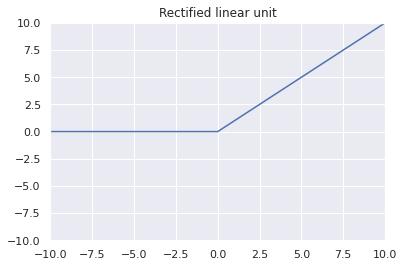

In [ ]:
#@title Activation functions

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
z = np.arange(-10, 10, .1)
zero = np.zeros(len(z))


y = np.max([zero, z], axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y)
ax.set_ylim([-10, 10.0])
ax.set_xlim([-10, 10.0])
ax.grid(True)

ax.set_title('Rectified linear unit')

plt.show()

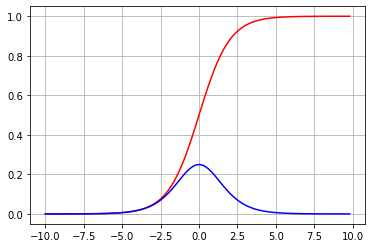

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x):
    s = 1/(1+np.exp(-x))   
    return s

def sigmoid_derivative(x):
    s = sigmoid(x)
    ds = s*(1-s)
    return ds

values = np.arange(-10,10,0.2)

plt.plot(values, sigmoid(values), 'r')
plt.plot(values, sigmoid_derivative(values), 'b')
plt.grid()


# create the graph
plt.show()

Let's move with using the high-level api for now but we'll revisit this notion later when we import modules from Tensorflow Hub 

In [ ]:
#Our first neural net!

In [ ]:
y = gates['XOR']

In [ ]:
mlp = tf.keras.Sequential()

In [ ]:
#your code here 
mlp.add(tf.keras.layers.Dense(16, input_dim=2, activation='relu'))
mlp.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
mlp.compile(
    optimizer=tf.keras.optimizers.SGD(lr = 0.01, 
                              momentum = 0.6),
    loss='binary_crossentropy',
    metrics=['accuracy']
    
)

In [ ]:
history = mlp.fit(X, y, batch_size=1, epochs=1000, verbose=0)

In [ ]:
(mlp.predict(X) > 0.5).astype('int32')

array([[0],
       [1],
       [1],
       [0]], dtype=int32)

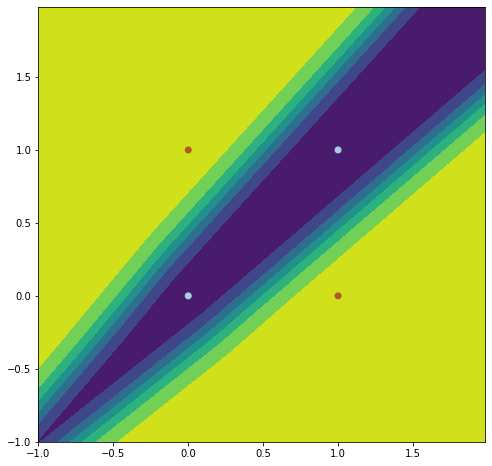

In [ ]:
plot_decision(X,y,mlp, output_class=False)

In [ ]:
## Now it's your turn

In [ ]:
from sklearn.datasets import make_circles

X, targets = make_circles(n_samples = 1000, factor=0.1)
X_train = X[250:, :]
X_test = X[:250, :]
y_train = targets[250:]
y_test = targets[:250]

feature_vector = len(X_train[0])
input_shape = (feature_vector,)

In [ ]:
#Your code here 
circles = tf.keras.Sequential()
circles.add(tf.keras.layers.Dense(16, input_dim=2, activation = 'relu'))
circles.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [ ]:
circles.compile(optimizer=tf.keras.optimizers.SGD(), loss='binary_crossentropy', metrics='accuracy')

In [ ]:
history = circles.fit(X_train, y_train,
                      epochs=200,
                      batch_size=64,
                      verbose=1,
                      validation_split=0.2)

Epoch 1/200
10/10 [==============================] - 1s 58ms/step - loss: 0.6988 - accuracy: 0.5069 - val_loss: 0.6966 - val_accuracy: 0.5333
Epoch 2/200
10/10 [==============================] - 0s 6ms/step - loss: 0.7013 - accuracy: 0.4850 - val_loss: 0.6938 - val_accuracy: 0.5333
Epoch 3/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.4943 - val_loss: 0.6911 - val_accuracy: 0.6067
Epoch 4/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4896 - val_loss: 0.6884 - val_accuracy: 0.6600
Epoch 5/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5607 - val_loss: 0.6857 - val_accuracy: 0.6600
Epoch 6/200
10/10 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5810 - val_loss: 0.6830 - val_accuracy: 0.6800
Epoch 7/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.6320 - val_loss: 0.6803 - val_accuracy: 0.7067
Epoch 8/200


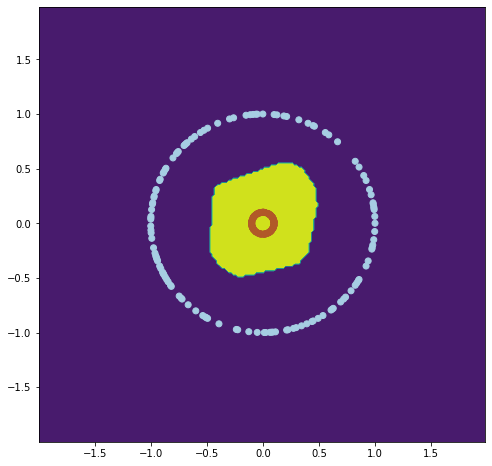

In [ ]:
plot_decision(X_test,y_test,circles, output_class=True)

In [ ]:
#What about the functional API?
input = tf.keras.Input(shape = (2,))
dense = tf.keras.layers.Dense(16, activation='relu')(input)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

functional_circles = tf.keras.Model(inputs=[input], outputs=[output])

functional_circles.compile(optimizer=tf.keras.optimizers.SGD(), loss='binary_crossentropy', metrics='accuracy')

history = functional_circles.fit(X_train, y_train,
                      epochs=200,
                      batch_size=64,
                      verbose=1,
                      validation_split=0.2)


Epoch 1/200
10/10 [==============================] - 1s 21ms/step - loss: 0.6968 - accuracy: 0.4731 - val_loss: 0.6974 - val_accuracy: 0.4467
Epoch 2/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5121 - val_loss: 0.6946 - val_accuracy: 0.3733
Epoch 3/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.4699 - val_loss: 0.6920 - val_accuracy: 0.4800
Epoch 4/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.6185 - val_loss: 0.6893 - val_accuracy: 0.5267
Epoch 5/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.6571 - val_loss: 0.6866 - val_accuracy: 0.5733
Epoch 6/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6828 - accuracy: 0.6891 - val_loss: 0.6840 - val_accuracy: 0.6333
Epoch 7/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6805 - accuracy: 0.7350 - val_loss: 0.6815 - val_accuracy: 0.7133
Epoch 8/200


#More data please!

In [ ]:
#mnist
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()



11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train[0].shape

(28, 28)

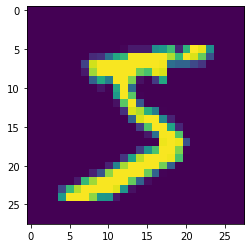

In [ ]:
plt.imshow(X_train[0])

We can think of digital images as the discrete pixel intensity at a specific  pixel location - **I(x,y)** Let's visualise it in 3D to get a better idea!

In [ ]:
import cv2

image = X_train[2]
inception = cv2.imread('/content/drive/My Drive/testing ground/cv-intro/data/inception2.jpg')
gray = cv2.cvtColor(inception, cv2.COLOR_BGR2GRAY)

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

def plot_3d(a,b, pic):

  xx, yy = np.mgrid[0:pic.shape[0], 0:pic.shape[1]]
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca(projection='3d')
  ax.plot_surface(xx, yy, pic ,rstride=1, cstride=1, cmap=plt.cm.gray,linewidth=0.01)
  ax.view_init(a, b)

  plt.show()


def f(a, b, pic):
    plot_3d(a,b, pic)
    

In [ ]:
inception = interactive(f,pic=widgets.fixed(gray), a=80, b=30)
display(inception)

interactive(children=(IntSlider(value=80, description='a', max=240, min=-80), IntSlider(value=30, description=…

In [ ]:
mnist = interactive(f,pic=widgets.fixed(image), a=80, b=30)
display(mnist)

interactive(children=(IntSlider(value=80, description='a', max=240, min=-80), IntSlider(value=30, description=…

To classify inception posters or indeed specific objects regardless of the context of the poster we'd need something a little more complex like a convolutional neural network but for now let's look at how we can tackle something a little simpler and visit the classic mnist handwriting dataset

In [ ]:
X_train[0].shape

(28, 28)

In [ ]:
#Can you normalise the images and why do we go about doing this?
train_images = X_train / 255.0
test_images = X_test / 255.0

In [ ]:
#How about reshaping?
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

In [ ]:
train_images[0].shape

(784,)

Now it's over to you!

- Hints - you can avoid having to one hot encode you labels by using sparse catergorical as you loss

- What about our last layer? Last time we were dealing with a binary classifiction problem so where are we headed here?

In [ ]:
mnist = tf.keras.Sequential()

mnist.add(tf.keras.layers.Dense(16, activation='relu', input_dim=784))
mnist.add(tf.keras.layers.Dense(16, activation='relu'))
mnist.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
mnist.compile(optimizer = 'rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
path = '/content/drive/My Drive/testing ground/toronto-ml/intro-to-tf2/models'

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
ms = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history = mnist.fit(train_images, y_train, epochs=300, 
                    batch_size=64,
                    validation_data=(test_images, y_test),
                    callbacks=[es],
                    verbose = 2)

In [ ]:
#functional

input = tf.keras.Input(shape = (784,))

x = tf.keras.layers.Dense(16, activation='relu')(input)
x = tf.keras.layers.Dense(16, activation='relu')(x)

output = tf.keras.layers.Dense(10, activation='softmax')(x)
mnist_f = tf.keras.Model(inputs = [input], outputs = [output])

mnist_f.compile(optimizer = 'rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = mnist_f.fit(train_images, y_train, epochs=300, 
                    batch_size=64,
                    validation_data=(test_images, y_test),
                    verbose = 2)



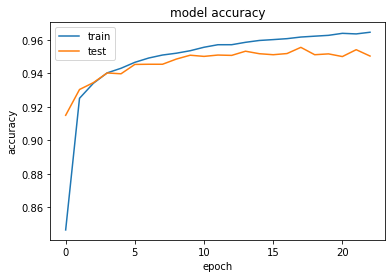

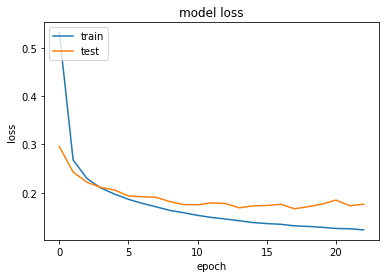

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#load saved model
mnist_load = tf.keras.models.load_model('/content/drive/My Drive/testing ground/toronto-ml/intro-to-tf2/models/')

In [ ]:
import numpy as np
predictions = mnist.predict(test_images[:5])

print(np.argmax(predictions, axis=1))

[7 2 1 0 4]


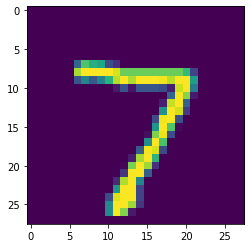

In [ ]:
plt.imshow(X_test[0])

In [ ]:
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [ ]:
class_names[np.argmax(predictions, axis=1)[0]]

'seven'

In [ ]:
predictions_all = mnist.predict(test_images)

In [ ]:
import cv2

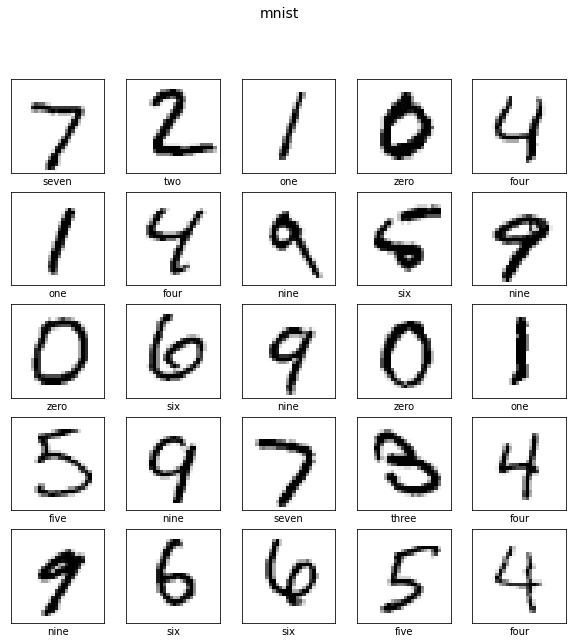

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_test[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[np.argmax(predictions_all, axis=1)[i]])
plt.suptitle('mnist', fontsize=14)        
plt.show()

In [ ]:
#try the same with cifar100 and our new callback!
import tensorflow as tf


(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np


class_names2 = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]


class_names = ["Plane","Car","Bird","Cat","Deer",
               "Dog", "Frog","Horse","Boat","Truck"]

def show_frame(epoch, logs):
  clear_output(wait=True)


  predictions_all = cifar.predict(test_images)


  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(predictions_all, axis=1)[i]])
  plt.suptitle(f"Epoch: {epoch}", fontsize=14)
  plt.show()

  


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
cg = tf.keras.callbacks.LambdaCallback(on_epoch_end=show_frame)
tb = tf.keras.callbacks.TensorBoard(log_dir='./logs')
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10)

In [ ]:
#train_images[0].shape

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

train_images = X_train.astype('float32') / 255.0
test_images = X_test.astype('float32') / 255.0


#train_images = train_images.reshape((-1, 784))
#test_images = test_images.reshape((-1, 784))
input_shape = (32,32,3)

cifar = tf.keras.Sequential()

cifar.add(Conv2D(128, kernel_size=(3, 3),input_shape=input_shape, activation='relu', padding = 'same'))
cifar.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cifar.add(MaxPooling2D(pool_size=(2, 2)))
cifar.add(Dropout(0.25))

cifar.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'))
cifar.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
cifar.add(MaxPooling2D(pool_size=(2, 2)))
cifar.add(Dropout(0.25))


cifar.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same'))
cifar.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
cifar.add(MaxPooling2D(pool_size=(2, 2)))
cifar.add(Dropout(0.5))



cifar.add(Flatten())
cifar.add(Dense(1024, activation='relu'))
cifar.add(Dropout(0.5))
cifar.add(Dense(10, activation='softmax'))



cifar.compile(tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])



In [ ]:
cifar.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 256)        

In [ ]:
train_images.shape

(50000, 32, 32, 3)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 1534), started 0:25:38 ago. (Use '!kill 1534' to kill it.)

<IPython.core.display.Javascript object>

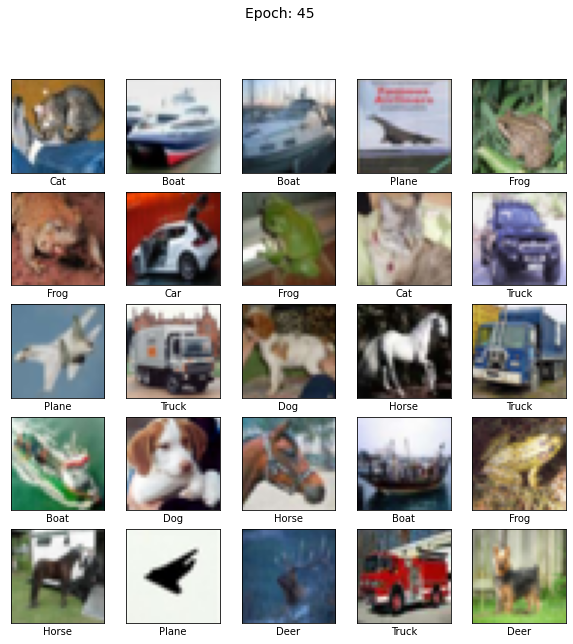

Epoch 00046: early stopping


In [ ]:
history = cifar.fit(train_images, y_train, epochs=300, 
                    validation_data=(test_images, y_test),
                    batch_size = 128,
                    callbacks=[es,cg, tb, rlr],
                    verbose=1  
                    )

#Let's take it even futher!

Head over to the bonus round notebook and let's take a look.

 We won't delve into transfer learning this time around, but the whole basis is there for you to look at. Note that I've unfrozen every single single for demonstration purposes

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights="Imagenet")


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
show_local_mp4_video('/content/drive/My Drive/testing ground/toronto-ml/intro-to-tf2/images/activations/all_layers_final.mp4')

In [ ]:
!pip install --upgrade IPython

Requirement already up-to-date: IPython in /usr/local/lib/python3.6/dist-packages (7.16.1)


In [ ]:
upload = False
from kora.drive import upload_public
from IPython.display import HTML

url = 'https://drive.google.com/uc?id=11eibnodv9AyJelpKSZZFUk-na0AHumEy'

if upload:
  url = upload_public('/content/drive/My Drive/testing ground/toronto-ml/intro-to-tf2/images/activations/all_layers_final.mp4')


HTML(f"""<video src={url} width=800 height=500 controls/>""")

#There's more! 

Up next we have somewhat of a sequel to this workshop where we'll be looking at deploying Tensorflow models to the edge! 


For now it's worth noting that the ecosystem goes even further with goodies like the Tensorflow Object Detection API and tf-agents but we'll be looking at that in our next session in what is essentially the sequel to this worskhop! Thanks everybody!


###Useful links

- [Tensorflow Hub](https://www.tensorflow.org/hub)
-[Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection)
-[Tf-agents](https://github.com/tensorflow/agents)
-[Openvino Toolkit](https://docs.openvinotoolkit.org/latest/index.html)

